In [349]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import astropy.units as u
from astropy.constants import G
G = G.to(u.pc * u.Msun**-1 * (u.km / u.s)**2)
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
import gala.units as gu

from gala.units import galactic
from gala.potential import NFWPotential
from gala.dynamics import PhaseSpacePosition, MockStream
from gala.integrate import LeapfrogIntegrator

from Gala_stream import run
from stream_track import unwrap, get_track_from_orbits


In [382]:
# Parameters

mass_halo = 1e12 * u.Msun
r_s = 10 * u.kpc

mass_plummer = 1e8 * u.Msun
r_plummer = 1 * u.kpc

time = 1 * u.Gyr
dt   = 1 * u.Myr

pos_p = [-50, 0, 1] * u.kpc
vel_p = [0, 175, 0] * u.km/u.s

N  = 999
dN = 1

orbit_pos_p, orbit_pos_N, leading_arg, trailing_arg = run(mass_halo, r_s, mass_plummer, r_plummer, time, dt, pos_p, vel_p, N, dN)

  0%|          | 0/999 [00:00<?, ?it/s]/Users/davidchemaly/miniforge3/envs/Ant/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 999/999 [00:10<00:00, 92.96it/s]


In [383]:
n = 11
keep_arg = np.linspace(0, len(leading_arg), n)
leading_idx = np.array(leading_arg)[keep_arg.astype(int)[:-1]]


x_leading = orbit_pos_N[:,leading_idx, 0].T
y_leading = orbit_pos_N[:,leading_idx, 1].T

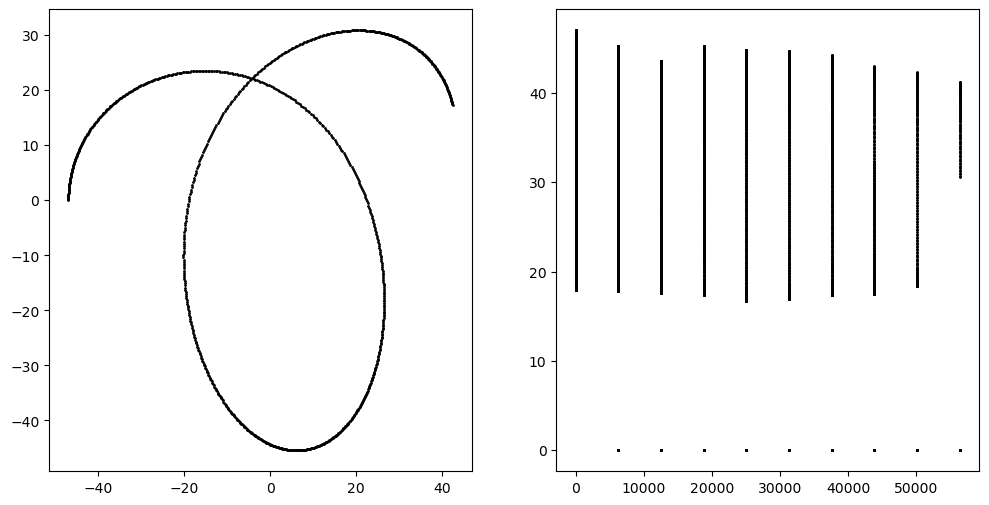

In [397]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_leading[0], y_leading[0], s=1, c='k')
plt.subplot(1,2,2)
r_leading = np.sqrt(x_leading**2 + y_leading**2)
theta_leading = np.arctan2(y_leading, x_leading)
theta_shifted = 
plt.scatter(unwrap(theta_leading), r_leading, s=1, c='k')


In [388]:
r_leading = np.sqrt(x_leading**2 + y_leading**2)
theta_leading = np.arctan2(y_leading, x_leading)
theta_leading_shifted = theta_leading - theta_leading[0,0]

if theta_leading_shifted[0,1] < 0:
    theta_unwrap = unwrap(-theta_leading_shifted.value)
else:
    theta_unwrap = unwrap(theta_leading_shifted.value)

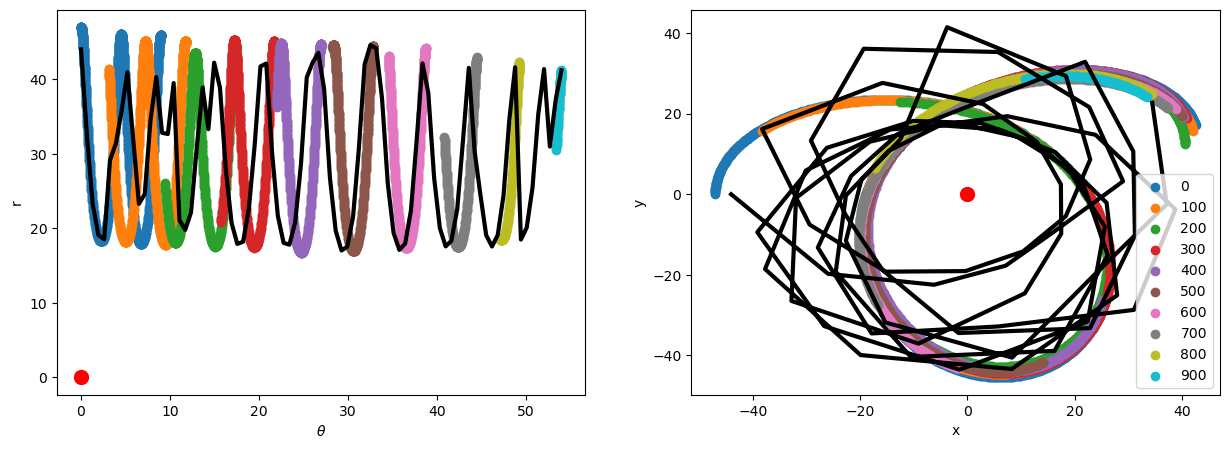

In [389]:
# Get the track from the orbits
def plot_track_from_orbits(x_pos, y_pos, args, mean_bin=51):

    first_theta = []
    for index, i in enumerate(args):
        x = x_pos[index, i//2:]
        y = y_pos[index, i//2:]
        first_theta.append(np.arctan2(y[0], x[0]))
    adjust_theta = unwrap( first_theta - first_theta[0])

    x_all = []
    y_all = []
    r_all = []
    theta_all = []
    for index, i in enumerate(args):
        x = x_pos[index, i+1:]
        y = y_pos[index, i+1:]
        x_all.extend(x)
        y_all.extend(y)
        r = np.sqrt(x**2 + y**2)
        theta = -np.arctan2(y, x)
        theta_shifted = theta - theta[0]
        theta_unwrapped = unwrap(theta_shifted + adjust_theta[index])

        r_all.extend(r)
        theta_all.extend(theta_unwrapped)

        plt.subplot(1,2,1)
        plt.scatter(theta_unwrapped, r)
        plt.xlabel(r'$\theta$')
        plt.ylabel('r')
        plt.subplot(1,2,2)
        plt.scatter(x,y, label=f'{i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

    def average_column(x,y):
        bins = np.linspace(np.min(x), np.max(x), mean_bin)

        # Bin the x array
        binned_x = np.digitize(x, bins)

        # Create a DataFrame for easy calculation
        df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

        # Group by the bin and calculate mean
        average_y_per_bin = df.groupby('bin')['y'].mean()

        return average_y_per_bin.to_numpy()

    r_mean = average_column(theta_all, r_all)
    theta_mean = np.linspace(np.min(theta_all), np.max(theta_all), len(r_mean))
    theta_norm = (theta_mean + first_theta[0] + np.pi) % (2 * np.pi) - np.pi 

    plt.subplot(1,2,1)
    plt.plot(theta_mean, r_mean, 'k', linewidth=3)
    plt.scatter(0,0,s=100,color='r')
    plt.subplot(1,2,2)
    x_mean = r_mean*np.cos(theta_norm)
    y_mean = r_mean*np.sin(theta_norm)
    plt.scatter(0,0,s=100,color='r')
    plt.plot(x_mean, y_mean, 'k', linewidth=3)


plt.figure(figsize=(15,5))
plot_track_from_orbits( x_leading.value, y_leading.value, leading_idx, mean_bin=101)

In [377]:
x_leading.shape

(10, 1000)

In [375]:
leading_idx

array([   0,  400,  800, 1200, 1600, 2000, 2400, 2800, 3200, 3600])

In [376]:
x.shape

AttributeError: 'Symbol' object has no attribute 'shape'